In [212]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    %load_ext autoreload
%autoreload 2


In [213]:
from utils.core import Load_data
import pandas as pd
from Model.preprocessing.pipelines import ProcessData
from Model.preprocessing.datasetManager import DatasetManger
from Model.base.train import cross_validation
from Model.base.model import make_model
from Model.base.logger import LoggerManager
import tensorflow as tf
from Model.base.evaluator import EvalutionClassifer, Drow, Drow_mean, Save_fig
from Model.base.augmentation import Augmentation, Strategies
from ydata_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, RocCurveDisplay, classification_report
from sklearn.model_selection import GridSearchCV

In [214]:
batch_size = 32
test_size = 0.20
val_size = 0.20
epoch = 500
lr = 9e-2
cv = 20
model_description = "same"
model_number = 18
Shuffle = True
Scheduler = True
METRICS = [
    tf.keras.metrics.BinaryAccuracy,
    tf.keras.metrics.Precision,
    tf.keras.metrics.Recall,
]
loss = tf.keras.losses.BinaryCrossentropy
trained_modelPath = "./trained_model"
plotPath = "./plots"

In [215]:
dataset_pd = Load_data("../dataset/metadata.csv")
dataset_pd.iloc[109] = dataset_pd.iloc[109].fillna(0.9)
dataset_pd = dataset_pd.drop(["annot_id"], axis=1)

In [216]:
X = dataset_pd.drop("histopath_diagnosis", axis=1)
Y = dataset_pd['histopath_diagnosis']

In [217]:
managerdataset = DatasetManger(
    X, Y, batch_size=batch_size, n_splits=2, test_size=test_size)
features_train, label_train, features_test, label_test = managerdataset.split()[
    0]

In [218]:
categorical_features = ["sex", "location"]

numerical_features = ["ti-rads_level", "size_x", "size_y", "size_z", "age"]

Ti_rads_featurea = ["ti-rads_composition", "ti-rads_echogenicity",
                    "ti-rads_margin", "ti-rads_shape", "ti-rads_echogenicfoci"]

features_train = ProcessData(
    features_train, categorical_features, numerical_features, Ti_rads_featurea)

features_test = ProcessData(
    features_test, categorical_features, numerical_features, Ti_rads_featurea)

In [219]:
augmentor_training = Augmentation(features_train, label_train)
features_train, label_train = augmentor_training.generate(
    Strategies.OverSampling)
augmentor_test = Augmentation(features_test, label_test)
features_test, label_test = augmentor_test.generate(Strategies.OverSampling)

In [220]:
features_train = features_train.to_numpy()
label_train = label_train.to_numpy()
features_test = features_test.to_numpy()
label_test = label_test.to_numpy()

In [221]:
classifer = RandomForestClassifier(max_depth=50, n_estimators=1000,random_state=0)

In [222]:
classifer.fit(features_train, label_train)

RandomForestClassifier(max_depth=50, n_estimators=1000, random_state=0)

In [ ]:
parameter = {
    "max_depth" : [],
    "n_estimators": []
}
grid_searcher = GridSearchCV(classifier, parameter)
grid_searcher.fit(features_train, label_train)

In [223]:
def Draw_ROC(model, x, y):
    prediction_value = model.predict(x)
    fpr, tpr, thresholds = roc_curve(y, prediction_value)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(
        fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=f'estimator RF')
    display.plot()
    return display

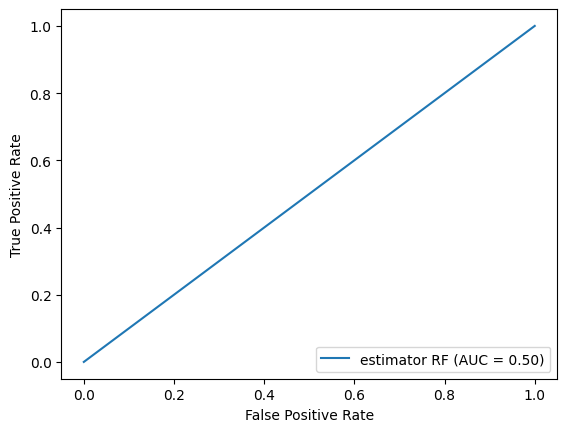

In [224]:
Draw_ROC(classifer, features_test, label_test )

In [225]:
print(classification_report(label_test, classifer.predict(features_test)))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        36
           1       0.00      0.00      0.00        36

    accuracy                           0.50        72
   macro avg       0.25      0.50      0.33        72
weighted avg       0.25      0.50      0.33        72



C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
